In this document, I'm going to be a bit more harsh on the gene filtering

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from constclust import cluster, reconcile, aggregate, plotting

In [2]:
adata = sc.read("../data/inproc/seurat_w_ensemblids.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 3412 × 27553 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.6', 'seurat_clusters', 'nCount_ADT', 'nFeature_ADT', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'log1p_total_counts_human', 'pct_counts_human', 'total_counts_mouse', 'log1p_total_counts_mouse', 'pct_counts_mouse'
    var: 'detection_rate', 'gmean', 'variance', 'residual_mean', 'residual_variance', 'mouse', 'human', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ensembl_id'
    obsm: 'X_pca', 'X_tsne'
    layers: 'counts', 'logcounts'

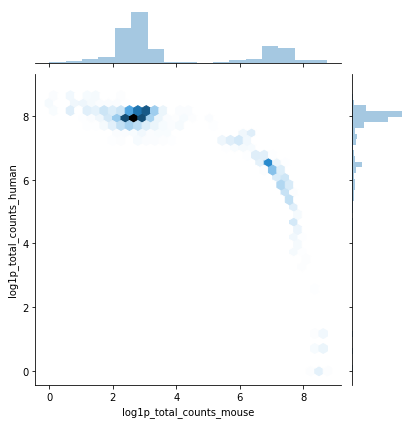

In [4]:
sns.jointplot(x="log1p_total_counts_mouse", y="log1p_total_counts_human", data=adata.obs, kind="hex")

In [6]:
adata.obs["human_total_frac"] = adata.obs["total_counts_human"] / (adata.obs["total_counts_human"] + adata.obs["total_counts_mouse"])

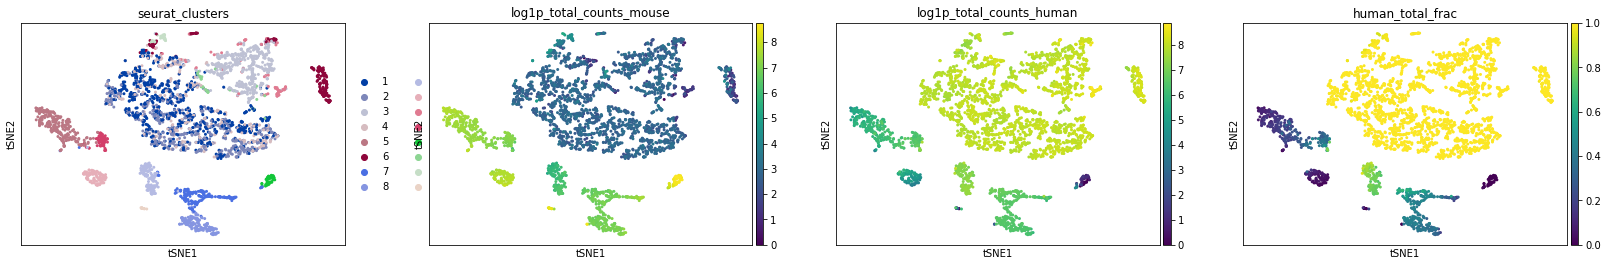

In [7]:
sc.pl.tsne(adata, color=["seurat_clusters", "log1p_total_counts_mouse", "log1p_total_counts_human", "human_total_frac"])

In [8]:
assert not (adata.X != adata.layers["counts"]).toarray().any()

In [9]:
adata.X = adata.layers["logcounts"]

In [10]:
(adata.obsm["X_pca"] == 0).all(axis=1).shape

(3412,)

In [11]:
adata.obsm["seurat_pca"] = adata.obsm["X_pca"].copy()

In [12]:
sc.pp.pca(adata)

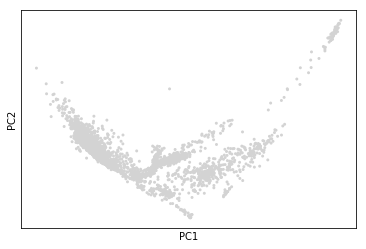

In [13]:
sc.pl.pca(adata)

In [14]:
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

/usr/local/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../../usr/local/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/usr/local/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../../../usr/local/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/usr/local/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the nop

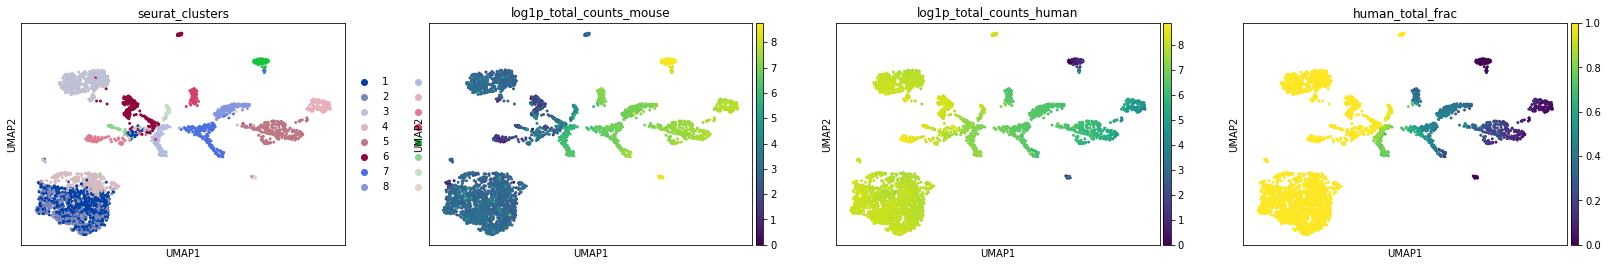

In [15]:
sc.pl.umap(adata, color=["seurat_clusters", "log1p_total_counts_mouse", "log1p_total_counts_human", "human_total_frac"])

In [16]:
mean_human_frac = adata.obs.groupby("seurat_clusters")["human_total_frac"].mean()

In [17]:
mean_human_frac

seurat_clusters
1     0.994475
2     0.995144
3     0.995144
4     0.994816
5     0.174209
6     0.994422
7     0.411685
8     0.376749
9     0.785856
10    0.052028
11    0.997796
12    0.374952
13    0.000389
14    0.994192
15    0.972659
16    0.018552
Name: human_total_frac, dtype: float32

In [18]:
probably_human = adata[
    adata.obs["seurat_clusters"].isin(mean_human_frac.index[mean_human_frac > .5])
]

In [19]:
probably_human = probably_human[:, probably_human.var["human"]]

In [20]:
probably_human = probably_human.copy()

In [21]:
sc.pp.pca(probably_human)
sc.pp.neighbors(probably_human, n_neighbors=30)
sc.tl.umap(probably_human)

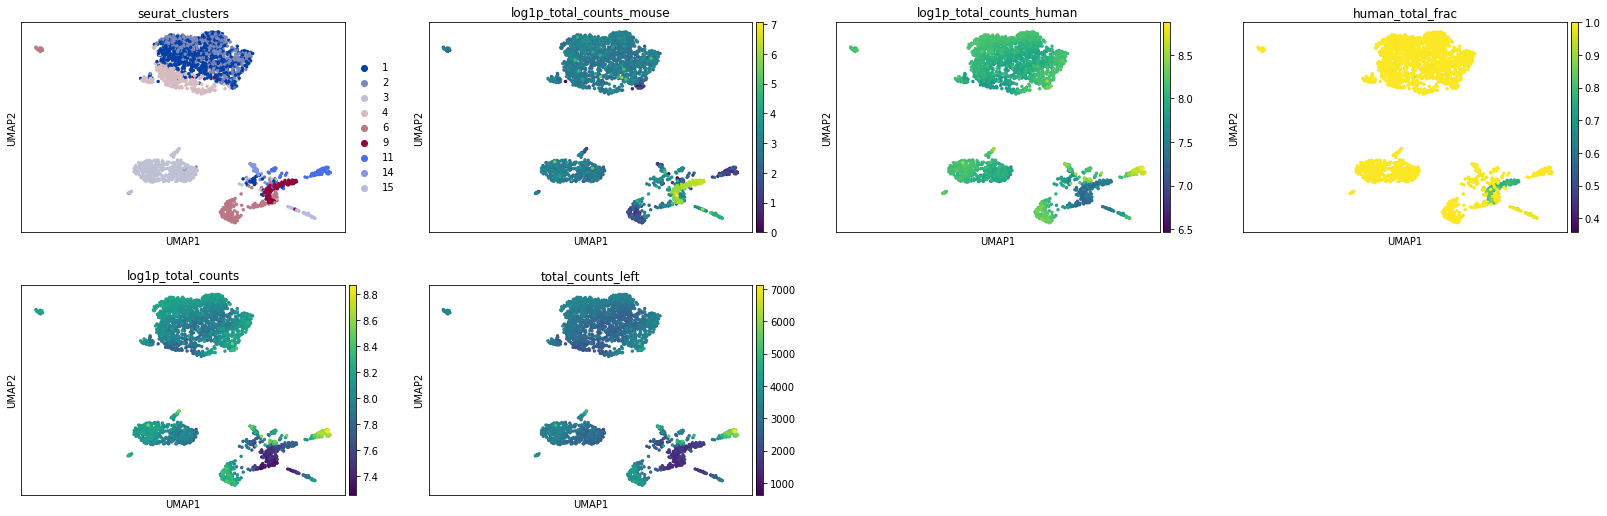

In [37]:
sc.pl.umap(probably_human, color=["seurat_clusters", "log1p_total_counts_mouse", "log1p_total_counts_human", "human_total_frac", "log1p_total_counts", "total_counts_left"])

In [26]:
sc.pp.filter_genes(probably_human, min_counts=1)


In [29]:
sns.distplot

(2546, 1)

In [ ]:
probably_human

In [36]:
probably_human.obs["total_counts_left"] = probably_human.layers["counts"].sum(axis=1)

In [38]:
sc.pp.pca(probably_human)
sc.pp.neighbors(probably_human, n_neighbors=30)
sc.tl.umap(probably_human)

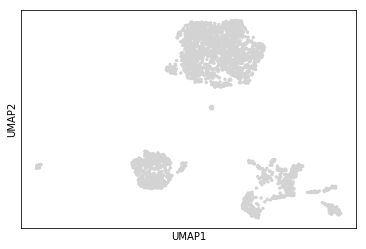

In [39]:
sc.pl.umap(probably_human)

In [41]:
probably_human.write("probably_human.h5ad", compression="gzip")

In [50]:
%%time
params, clusterings = cluster(
    probably_human,
    n_neighbors=np.linspace(15, 120, 4, dtype=int),
    resolutions=np.geomspace(0.05, 20, 50),
    random_state=[0,1,2,3],
    n_procs=4
)

Finding communities: 100%|██████████| 800/800 [07:56<00:00,  1.68it/s]


CPU times: user 6min 36s, sys: 21.6 s, total: 6min 57s
Wall time: 8min 13s


In [51]:
%time rec = reconcile(params, clusterings)

CPU times: user 830 ms, sys: 85.7 ms, total: 916 ms
Wall time: 933 ms


In [54]:
comps = rec.get_components(0.95)

comp 0 with 748 solutions and 24/24  min/max cells


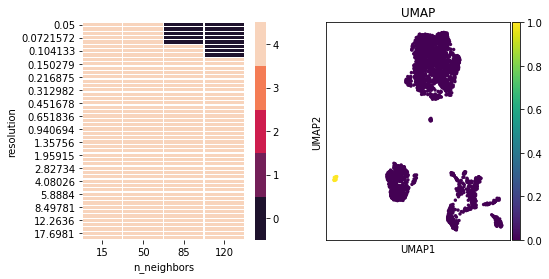

comp 1 with 611 solutions and 48/54  min/max cells


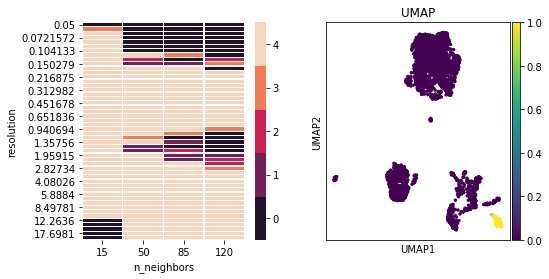

comp 2 with 604 solutions and 11/11  min/max cells


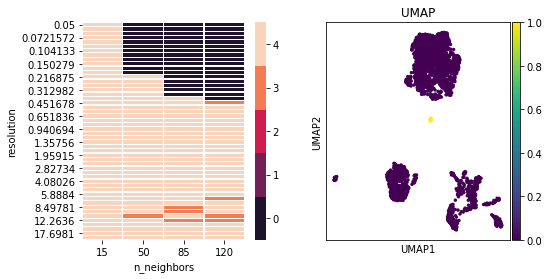

comp 3 with 466 solutions and 40/40  min/max cells


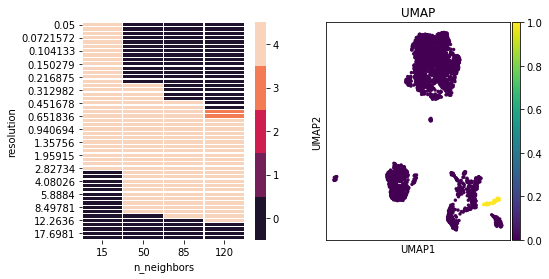

comp 4 with 466 solutions and 32/36  min/max cells


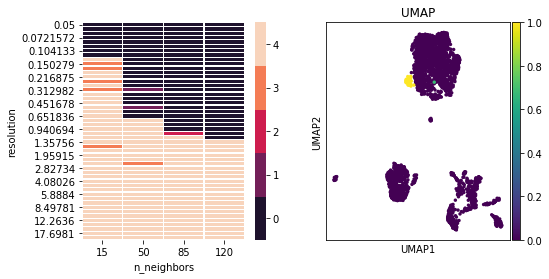

comp 5 with 457 solutions and 117/130  min/max cells


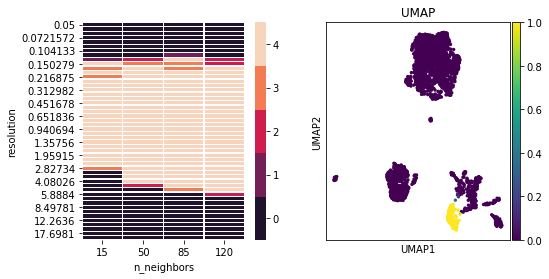

comp 6 with 387 solutions and 441/510  min/max cells


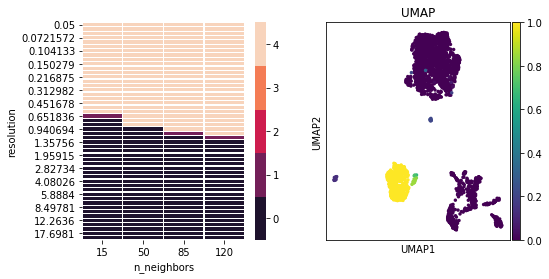

comp 7 with 310 solutions and 41/56  min/max cells


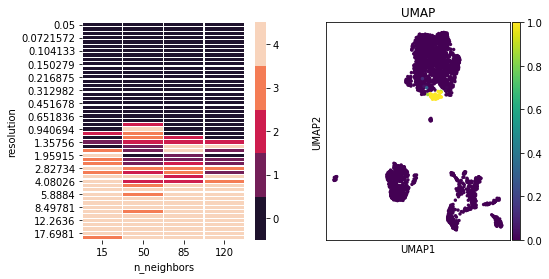

comp 8 with 256 solutions and 15/15  min/max cells


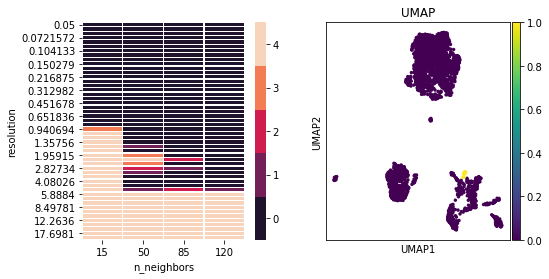

comp 9 with 230 solutions and 1435/1563  min/max cells


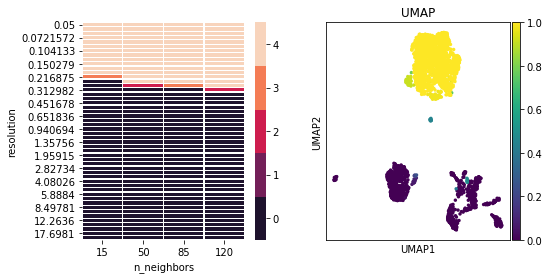

comp 10 with 151 solutions and 209/258  min/max cells


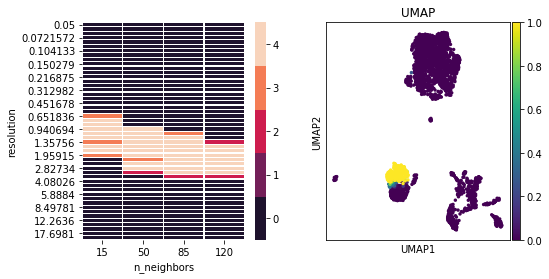

comp 11 with 146 solutions and 25/33  min/max cells


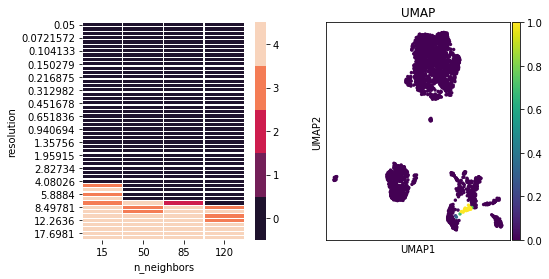

comp 12 with 139 solutions and 185/239  min/max cells


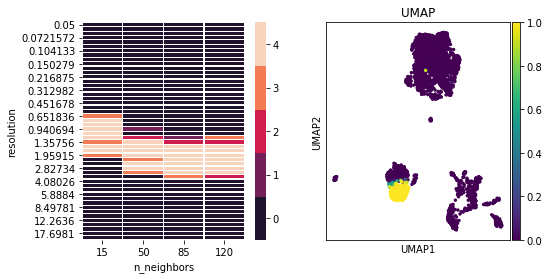

comp 13 with 135 solutions and 15/15  min/max cells


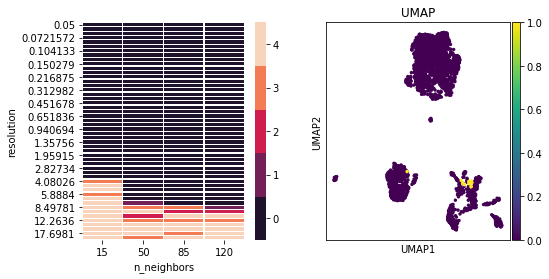

comp 14 with 124 solutions and 15/15  min/max cells


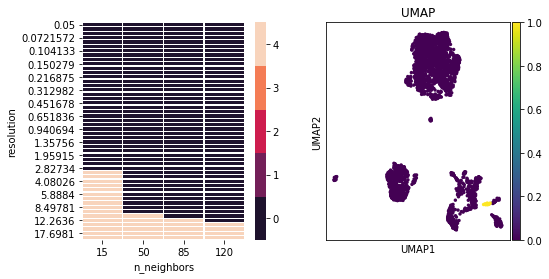

comp 15 with 120 solutions and 25/25  min/max cells


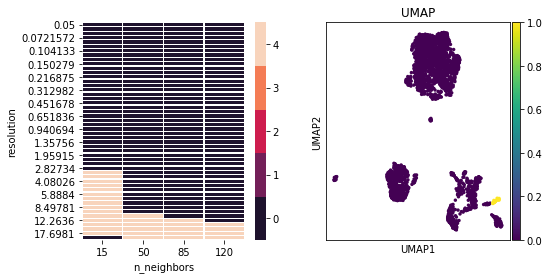

comp 16 with 92 solutions and 204/238  min/max cells


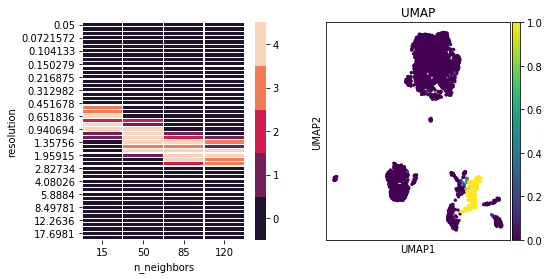

comp 17 with 87 solutions and 515/528  min/max cells


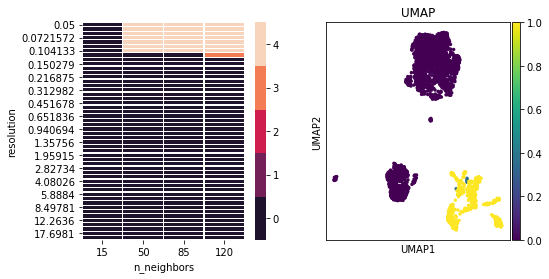

comp 18 with 83 solutions and 337/359  min/max cells


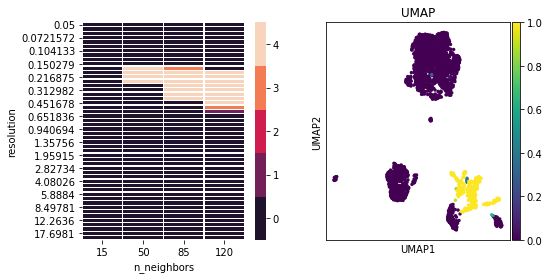

comp 19 with 83 solutions and 42/60  min/max cells


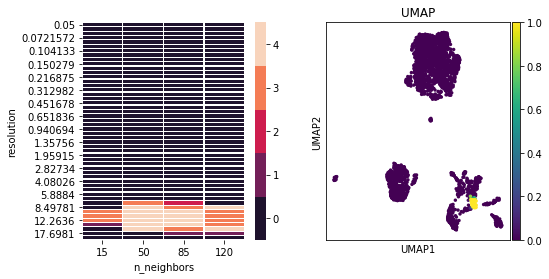

In [57]:
for i, c in enumerate(comps[:20]):
    print(f"comp {i} with {len(c)} solutions and {len(c.intersect)}/{len(c.union)}  min/max cells")
    plotting.component(c, probably_human)

In [75]:
comps_to_use = [0, 1, 2, 3, 4, 5, 7, 8,9, 10, 12]
probably_human.obs["consistent"] = ""
for i in comps_to_use:
    probably_human.obs.loc[comps[i].intersect_names, "consistent"] = str(i)

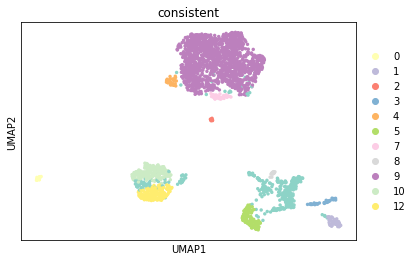

In [93]:
sc.pl.umap(probably_human, color="consistent", palette="Set3")

In [104]:
list(probably_human.obs["consistent"].cat.categories).index("8")

8

In [101]:
probably_human.uns["consistent_colors"][0]

'#8dd3c7'

In [105]:
probably_human.uns["consistent_colors"][8]

'#d9d9d9'

In [89]:
probably_human.uns["consistent_colors"][0]

'#8dd3c7'

In [106]:
probably_human.uns["consistent_colors"][0] = '#d9d9d9'
probably_human.uns["consistent_colors"][8] = '#8dd3c7'

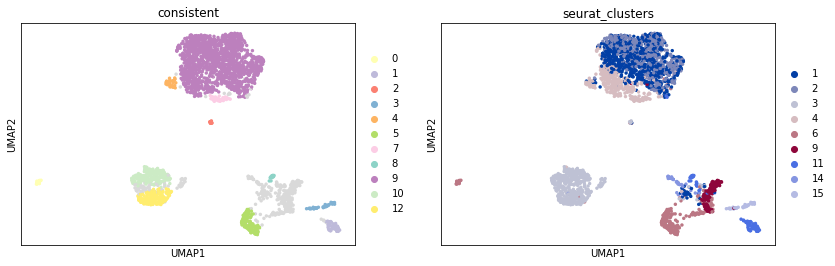

In [107]:
sc.pl.umap(probably_human, color=["consistent", "seurat_clusters"])

In [108]:
?sc.tl.rank_genes_groups

In [110]:
def de(adata, key, group1, group2, method="wilcoxon"):
    subset = adata[adata.obs[key].isin([group1, group2])].copy()
    sc.pp.filter_genes(subset, min_counts=1)
    sc.tl.rank_genes_groups(subset, key, groups=[group1, group2], n_genes=subset.shape[1], method=method)
    return sc.get.rank_genes_groups_df(subset, group1)

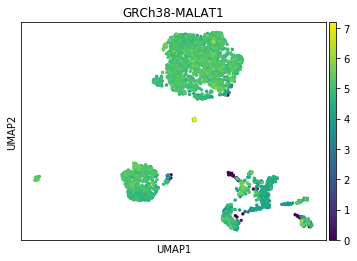

In [142]:
sc.pl.umap(probably_human, color="GRCh38-MALAT1")

In [111]:
de(probably_human, "consistent", "10", "12")

Trying to set attribute `.var` of view, making a copy.


,scores,names,logfoldchanges,pvals,pvals_adj
0,12.415457,GRCh38-RPS14,0.763918,2.154543e-35,1.198896e-31
1,11.846383,GRCh38-RPS15A,0.650899,2.246799e-32,8.334875e-29
2,11.199750,GRCh38-RPS18,0.746187,4.088874e-29,1.137627e-25
3,10.992774,GRCh38-RPL27A,0.815057,4.140043e-28,9.214907e-25
4,10.955988,GRCh38-MALAT1,0.482367,6.219608e-28,1.153634e-24
5,10.920531,GRCh38-B2M,0.565587,9.195611e-28,1.461971e-24
6,10.590788,GRCh38-RPS28,0.617520,3.288115e-26,4.574179e-23
7,10.071797,GRCh38-RPL30,0.468464,7.362048e-24,9.103582e-21
8,9.920665,GRCh38-HLA-B,0.808780,3.384945e-23,3.767106e-20
9,9.713689,GRCh38-TPT1,0.481131,2.636203e-22,2.667119e-19


In [141]:
probably_human.write("probably_human.h5ad", compression="gzip")

In [ ]:
for i, c in enumerate(comps):
    plotting.plot_co

In [49]:
np.linspace(15, 120, 8, dtype=int)

array([ 15,  30,  45,  60,  75,  90, 105, 120])

In [27]:
probably_human

AnnData object with n_obs × n_vars = 2546 × 15353 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.6', 'seurat_clusters', 'nCount_ADT', 'nFeature_ADT', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'log1p_total_counts_human', 'pct_counts_human', 'total_counts_mouse', 'log1p_total_counts_mouse', 'pct_counts_mouse', 'human_total_frac'
    var: 'detection_rate', 'gmean', 'variance', 'residual_mean', 'residual_variance', 'mouse', 'human', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ensembl_id', 'n_counts'
    uns: 'seurat_clusters_colors', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'seurat_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'

In [39]:
adata.obs_names

Index(['AAACCTGAGGTGCTTT', 'AAACCTGAGTTGCAGG', 'AAACCTGGTAATCGTC',
       'AAACCTGGTCATCGGC', 'AAACCTGGTCGTTGTA', 'AAACCTGTCAAGATCC',
       'AAACCTGTCATGCTCC', 'AAACCTGTCCGTTGTC', 'AAACCTGTCGTCCAGG',
       'AAACCTGTCTCCAGGG',
       ...
       'TTTGGTTTCTTCGGTC', 'TTTGTCAAGAAGGGTA', 'TTTGTCAAGCGTCAAG',
       'TTTGTCAAGCTACCGC', 'TTTGTCAAGGCATTGG', 'TTTGTCACAATCCGAT',
       'TTTGTCACAATGGACG', 'TTTGTCACAGGTCGTC', 'TTTGTCAGTAGCGCAA',
       'TTTGTCAGTGAGGGAG'],
      dtype='object', name='index', length=3412)

In [114]:
prot = sc.AnnData(pd.read_csv("../data/Swarbrick_metastatic_lymphnode.CITE.csv").T)

In [117]:
prot.layers["counts"] = prot.X.copy()

In [121]:
sc.pp.calculate_qc_metrics(prot, percent_top=(5, 10, 50), inplace=True)

In [125]:
prot_human = prot[probably_human.obs_names].copy()

In [126]:
sc.pp.calculate_qc_metrics(prot_human, percent_top=(5, 10, 50), inplace=True)

/Users/isaac/github/scanpy/scanpy/preprocessing/_qc.py:375: RuntimeWarning: invalid value encountered in true_divide
  return values / sums[:, None]


In [145]:
antibody_isotypes = pd.read_csv("../data/antibody_isotype.csv")

In [149]:
antibody_isotypes.index = antibody_isotypes["Antibody"]

In [154]:
antibody_isotypes.head()

,Antibody,Isotype
CD3,CD3,Mouse_IgG1
CD4,CD4,Mouse_IgG1
CD8a,CD8a,Mouse_IgG1
CD14,CD14,Mouse_IgG2b
CD15,CD15,Mouse_IgG1


In [153]:
antibody_isotypes = antibody_isotypes.loc[prot_human.var_names]

In [158]:
prot_human.var["isotype"] = antibody_isotypes["Isotype"]

In [160]:
prot_human.obs.drop(columns="isotype", inplace=True)

In [166]:
for k, g in prot_human.var.groupby("isotype"):
    prot_human.obs[f"mean_{k}_counts"] = prot_human[:, g.index].layers["counts"].mean(axis=1)
    prot_human.obs[f"total_{k}_counts"] = prot_human[:, g.index].layers["counts"].sum(axis=1)

In [161]:
prot_human.layers["counts"]

ArrayView([[283., 283.,   4., ...,   0.,   0.,   3.],
           [  0.,   0.,   0., ...,   0.,   0.,   0.],
           [ 25., 171.,  11., ...,   0.,   3.,   3.],
           ...,
           [294., 275.,   8., ...,   1.,   4.,   5.],
           [321., 231.,   5., ...,   0.,   2.,   0.],
           [206.,   7., 196., ...,   1.,   3.,   1.]], dtype=float32)

In [157]:
prot_human.obs.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_5_genes,pct_counts_in_top_10_genes,pct_counts_in_top_50_genes,consistent,leiden,isotype
AAACCTGAGTTGCAGG,88,4.488636,7631.0,8.940105,50.635565,70.895033,98.427467,9,8,nan
AAACCTGGTCGTTGTA,2,1.098612,2.0,1.098612,100.000000,100.000000,100.000000,,4,nan
AAACCTGTCAAGATCC,94,4.553877,8858.0,9.089190,52.777151,73.967035,97.753443,2,7,nan
AAACCTGTCATGCTCC,87,4.477337,5052.0,8.527738,56.452890,80.839272,98.594616,9,1,nan
AAACCTGTCCGTTGTC,92,4.532599,3031.0,8.016977,57.571758,76.608380,95.710986,10,5,nan


In [131]:
sc.pp.log1p(prot_human)

In [133]:
sc.pp.pca(prot_human)
sc.pp.neighbors(prot_human, use_rep="X", metric="cosine")
sc.tl.umap(prot_human)

/usr/local/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../../usr/local/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/usr/local/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../../../usr/local/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/usr/local/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the nop

In [134]:
prot_human.obs["consistent"] = probably_human.obs["consistent"]

In [136]:
prot_human.uns["consistent_colors"] = probably_human.uns["consistent_colors"]

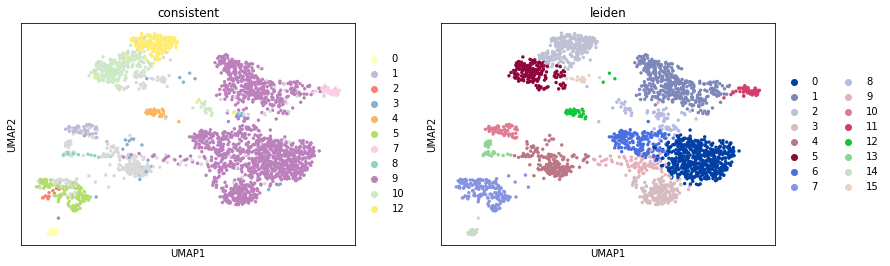

In [139]:
sc.pl.umap(prot_human, color=["consistent", "leiden"])

In [167]:
prot_human.write("./prot_human.h5ad")

In [138]:
sc.tl.leiden(prot_human)

In [132]:
?sc.pp.neighbors